## Top

In [11]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter1d # smooth manifold before interpolation
from scipy.ndimage import gaussian_filter # smooth manifold after interpolation
from matplotlib.colors import TwoSlopeNorm, LinearSegmentedColormap, Normalize # coloring
import seaborn as sns
# from mpl_toolkits.mplot3d import Axes3D
random.seed(42)
np.random.seed = 42

In [2]:
df = pd.read_csv('plotseaborn_d2.csv').iloc[:, 1:]
df

,PC1,PC2,PC3,MDS1,MDS2,PHQtot,expert_suicidality,LBA_suicidality
0,-0.011861,0.941181,-1.049142,-0.704004,1.210926,-0.305384,1.185342,1.054227
1,1.175250,-1.377800,0.319969,1.350919,-0.526551,-0.948474,-0.451681,-1.208756
2,-0.046657,0.719069,1.154828,-0.767422,-0.960893,-0.466156,-0.451681,-0.830706
3,-2.396301,0.944986,2.781667,-1.518680,-2.632004,0.498479,-0.451681,-1.067077
4,-4.308159,1.303968,0.232341,-1.840155,-0.225271,0.498479,-0.451681,-0.094313
...,...,...,...,...,...,...,...,...
950,1.147884,-0.467923,-0.449995,0.639912,0.407867,-0.305384,0.093993,0.499055
951,0.116054,0.520760,-0.514696,-0.377851,0.614654,-1.109246,-0.451681,-0.152508
952,0.555060,0.463811,-0.206444,-0.294606,0.334292,0.498479,2.822366,0.471470
953,0.750453,-0.002170,-1.215986,0.258431,1.219209,0.498479,1.185342,1.722167


## MDS viz

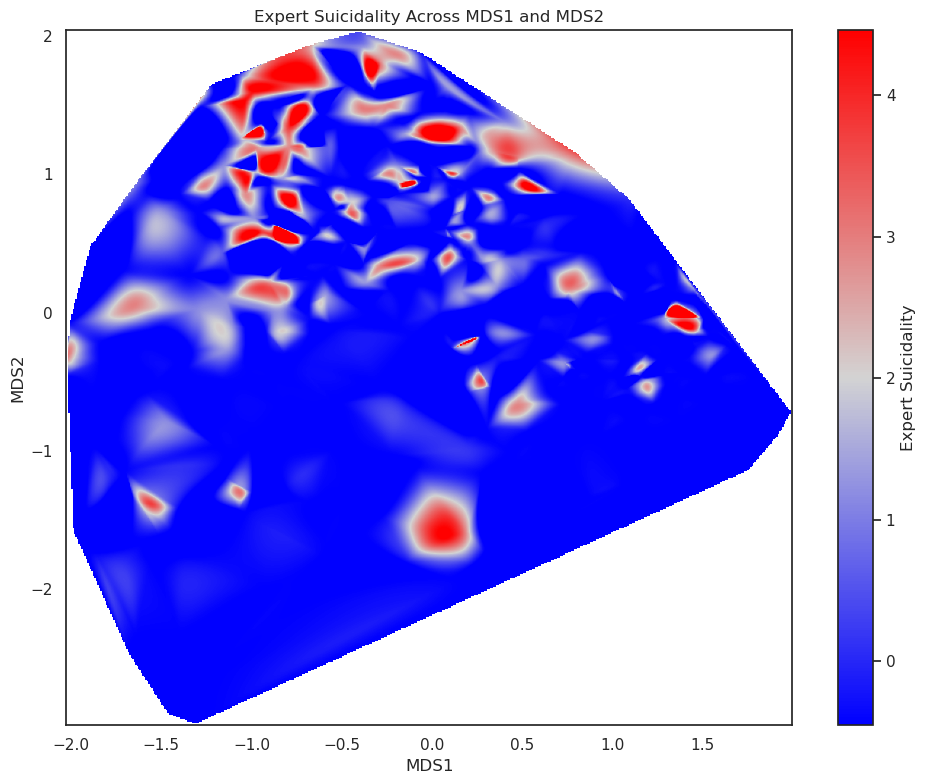

In [78]:
# Extract MDS coordinates and suicidality scores
x = df['MDS1']
y = df['MDS2']
c = df['expert_suicidality']

# Create grid over MDS1 and MDS2
grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 500),
    np.linspace(y.min(), y.max(), 500)
)

# Interpolate expert_suicidality values onto the grid
grid_c = griddata((x, y), c, (grid_x, grid_y), method='cubic')
#grid_c = gaussian_filter(grid_c, sigma=1)

# Define custom diverging colormap
colors = ['blue', 'lightgrey', 'red']
cmap = LinearSegmentedColormap.from_list("custom_diverging", colors)

# Compute normalization
vmin = np.nanmin(c)
vmax = np.nanmax(c)
mid_val = np.nanmedian(c)

# Ensure valid order for TwoSlopeNorm, fallback if not
if vmin < mid_val < vmax:
    norm = TwoSlopeNorm(vmin=vmin, vcenter=mid_val, vmax=vmax)
else:
    norm = Normalize(vmin=vmin, vmax=vmax)

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(grid_c, extent=(x.min(), x.max(), y.min(), y.max()),
               origin='lower', cmap=cmap, norm=norm, aspect='auto')

# Axis and title
ax.set_xlabel('MDS1')
ax.set_ylabel('MDS2')
ax.set_title('Expert Suicidality Across MDS1 and MDS2')

# Colorbar
fig.colorbar(im, ax=ax, label='Expert Suicidality')

plt.tight_layout()
plt.show()

## Discrete probabilistic manifold

### mod

In [95]:
from sklearn.mixture import BayesianGaussianMixture

# ---------------------------------------------------------------------------
# 1.  Data (df must already contain 'MDS1' and 'MDS2'; adjust as needed)
# ---------------------------------------------------------------------------
X  = df[['MDS1', 'MDS2']].to_numpy()

# ---------------------------------------------------------------------------
# 2.  Fit Bayesian Gaussian Mixture
# ---------------------------------------------------------------------------
bgm = BayesianGaussianMixture(
    n_components=7,
    covariance_type='full',
    weight_concentration_prior_type='dirichlet_process',
    weight_concentration_prior=1.0,
    random_state=42
).fit(X)

# Responsibilities → cluster + confidence for each point
probs   = bgm.predict_proba(X)
labels  = probs.argmax(axis=1)
conf    = probs.max(axis=1)
df_plot = df.assign(cluster=labels, conf=conf)

# ---------------------------------------------------------------------------
# 3.  Grid for density surface
# ---------------------------------------------------------------------------
nx = ny = 300
xx, yy = np.meshgrid(
    np.linspace(X[:, 0].min(), X[:, 0].max(), nx),
    np.linspace(X[:, 1].min(), X[:, 1].max(), ny)
)
grid   = np.column_stack([xx.ravel(), yy.ravel()])
logpdf = bgm.score_samples(grid).reshape(nx, ny)     # (nx, ny)

### plot Probability mod

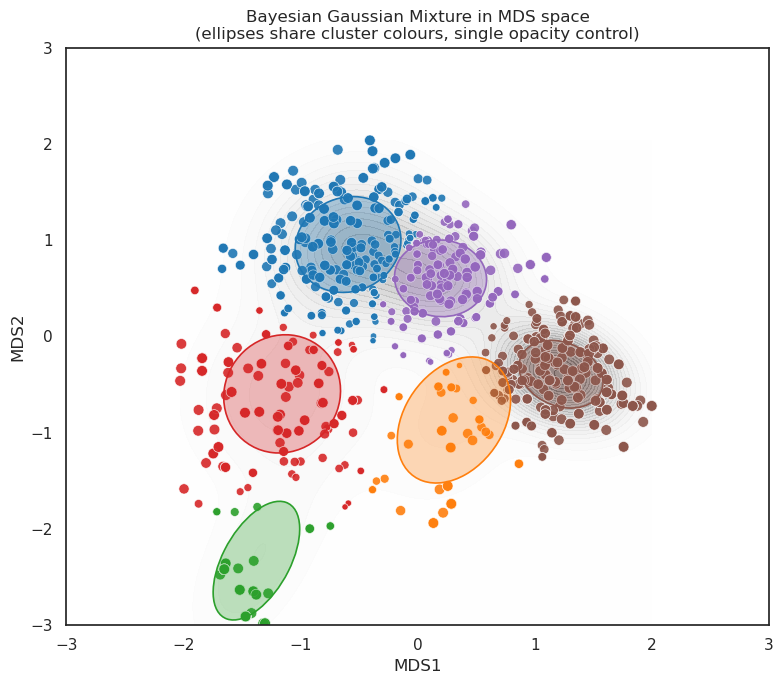

In [112]:
from matplotlib.patches import Ellipse
import matplotlib.colors as mcolors

# ── build a palette dict exactly once ────────────────────────────────────────
n_comp   = bgm.n_components
palette  = sns.color_palette("tab10", n_colors=n_comp)
pal_dict = {i: palette[i] for i in range(n_comp)}

# ── figure & background density ─────────────────────────────────────────────
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(8, 7))
ax.contourf(xx, yy, np.exp(logpdf), levels=25, cmap="Greys", alpha=.4)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)

# ── scatter points ──────────────────────────────────────────────────────────
sns.scatterplot(
    data=df_plot, x='MDS1', y='MDS2',
    hue='cluster', palette=pal_dict,
    size='conf', sizes=(20, 60), alpha=.9,
    ax=ax, legend=False
)

# ── ellipses with exactly ONE alpha control ─────────────────────────────────
def draw_ellipse(mu, cov, colour, ax, alpha_face=0.5, z=2.5):
    """Draw 1-σ ellipse coloured like the cluster; `alpha_face` = interior opacity."""
    U, s, _ = np.linalg.svd(cov)
    angle   = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)

    ax.add_patch(
        Ellipse(
            xy=mu,
            width=width,
            height=height,
            angle=angle,
            facecolor=mcolors.to_rgba(colour, alpha=alpha_face),  # single alpha here
            edgecolor=colour,
            lw=1.2,
            zorder=z                                             # above scatter
        )
    )

for k, (w, mu, cov) in enumerate(zip(bgm.weights_, bgm.means_, bgm.covariances_)):
    if w > 1e-3:
        draw_ellipse(mu, cov, pal_dict[k], ax, alpha_face=0.3)   # try 0.1-0.9

# ── labels & show ───────────────────────────────────────────────────────────
ax.set_xlabel('MDS1')
ax.set_ylabel('MDS2')
ax.set_title('Bayesian Gaussian Mixture in MDS space\n'
             '(ellipses share cluster colours, single opacity control)')
plt.tight_layout()
plt.show()

# PC viz

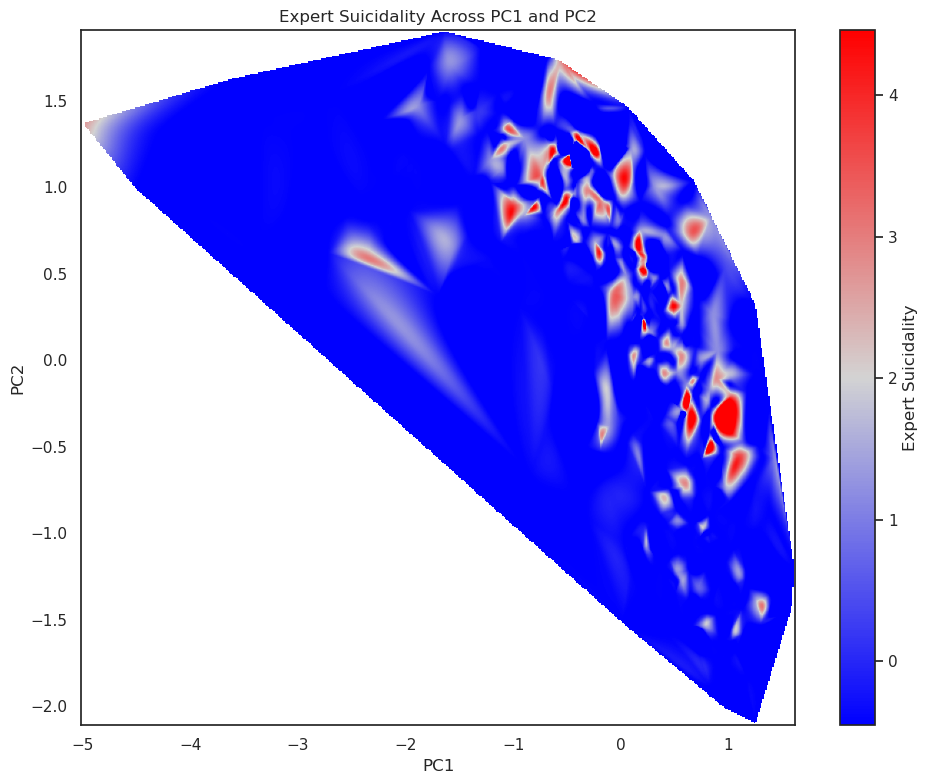

In [79]:
# Extract MDS coordinates and suicidality scores
x = df['PC1']
y = df['PC2']
c = df['expert_suicidality']

# Create grid over MDS1 and MDS2
grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 500),
    np.linspace(y.min(), y.max(), 500)
)

# Interpolate expert_suicidality values onto the grid
grid_c = griddata((x, y), c, (grid_x, grid_y), method='cubic')
#grid_c = gaussian_filter(grid_c, sigma=1)

# Define custom diverging colormap
colors = ['blue', 'lightgrey', 'red']
cmap = LinearSegmentedColormap.from_list("custom_diverging", colors)

# Compute normalization
vmin = np.nanmin(c)
vmax = np.nanmax(c)
mid_val = np.nanmedian(c)

# Ensure valid order for TwoSlopeNorm, fallback if not
if vmin < mid_val < vmax:
    norm = TwoSlopeNorm(vmin=vmin, vcenter=mid_val, vmax=vmax)
else:
    norm = Normalize(vmin=vmin, vmax=vmax)

# Plotting
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(grid_c, extent=(x.min(), x.max(), y.min(), y.max()),
               origin='lower', cmap=cmap, norm=norm, aspect='auto')

# Axis and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('Expert Suicidality Across PC1 and PC2')

# Colorbar
fig.colorbar(im, ax=ax, label='Expert Suicidality')

plt.tight_layout()
plt.show()

# Across datasets GMM

## Function

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import BayesianGaussianMixture
from matplotlib.patches import Ellipse
import matplotlib.colors as mcolors

def plot_bayesian_gaussian_mixture(
        df: pd.DataFrame,
        col_x: str,
        col_y: str,
        colour_col: str,
        n_components: int = 7,
        alpha_face: float = 0.3,
        figsize: tuple = (8, 7),
        random_state: int = 42,
        cmap_name: str = "coolwarm"
    ):
    """
    Bayesian Gaussian Mixture plot with:
      • dot size  ∝ mixture confidence
      • dot colour = blue→red gradient driven by `colour_col`
      • 1-σ ellipses per retained component

    Parameters
    ----------
    df          : DataFrame containing all required columns
    col_x, col_y: names of 2-D coordinate columns (e.g. 'MDS1', 'MDS2')
    colour_col  : numeric column for gradient colouring (e.g. 'LBA_suicidality')
    n_components: max mixture components (default 7)
    alpha_face  : ellipse interior opacity (0–1)
    figsize     : (width, height) in inches
    random_state: seed for reproducibility
    cmap_name   : any Matplotlib continuous colormap

    Returns
    -------
    fig, ax     : Matplotlib objects (so you can tweak or save later)
    """
    # -------- guard clauses -------------------------------------------------
    for c in (col_x, col_y, colour_col):
        if c not in df.columns:
            raise KeyError(f"Column '{c}' not found in DataFrame.")

    if not np.issubdtype(df[colour_col].dtype, np.number):
        raise TypeError(f"'{colour_col}' must be numeric for a gradient colour.")

    # -------- 1. data --------------------------------------------------------
    X = df[[col_x, col_y]].to_numpy()

    # -------- 2. Bayesian Gaussian Mixture ----------------------------------
    bgm = BayesianGaussianMixture(
        n_components=n_components,
        covariance_type="full",
        weight_concentration_prior_type="dirichlet_process",
        weight_concentration_prior=1.0,
        random_state=random_state
    ).fit(X)

    probs   = bgm.predict_proba(X)
    labels  = probs.argmax(axis=1)
    conf    = probs.max(axis=1)

    df_plot = df.assign(cluster=labels, conf=conf)

    # -------- 3. background density -----------------------------------------
    nx = ny = 300
    xx, yy = np.meshgrid(
        np.linspace(X[:, 0].min(), X[:, 0].max(), nx),
        np.linspace(X[:, 1].min(), X[:, 1].max(), ny)
    )
    grid   = np.column_stack([xx.ravel(), yy.ravel()])
    logpdf = bgm.score_samples(grid).reshape(nx, ny)

    # -------- 4. figure setup -----------------------------------------------
    sns.set_theme(style="white")
    fig, ax = plt.subplots(figsize=figsize)

    ax.contourf(xx, yy, np.exp(logpdf), levels=25, cmap="Greys", alpha=.4)
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)

    # continuous gradient mapping
    cmap  = plt.get_cmap(cmap_name)
    norm  = plt.Normalize(df_plot[colour_col].min(), df_plot[colour_col].max())

    # gradient-coloured scatter
    sns.scatterplot(
        data=df_plot,
        x=col_x, y=col_y,
        hue=colour_col,
        palette=cmap,
        hue_norm=norm,
        size="conf",
        sizes=(20, 60),
        alpha=0.9,
        edgecolor="none",
        legend=False,
        ax=ax
    )

    # colourbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    # fig.colorbar(sm, ax=ax, label=colour_col)
    # Capture the colorbar object
    cbar = fig.colorbar(sm, ax=ax, label=colour_col)
    # Increase tick label size
    cbar.ax.tick_params(labelsize=20)

    # -------- 5. ellipses ----------------------------------------------------
    comp_palette = sns.color_palette("tab10", n_colors=bgm.n_components)

    def draw_ellipse(mu, cov, colour):
        U, s, _ = np.linalg.svd(cov)
        angle   = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
        ax.add_patch(
            Ellipse(
                xy=mu, width=width, height=height, angle=angle,
                edgecolor="dimgray",     # or '#555555'# colour,
                facecolor=mcolors.to_rgba('lightgrey', alpha=alpha_face),   # or '#d3d3d3'# mcolors.to_rgba(colour, alpha=alpha_face),
                lw=1.2, zorder=2.5
            )
        )

    for k, (w, mu, cov) in enumerate(zip(bgm.weights_,
                                         bgm.means_,
                                         bgm.covariances_)):
        if w > 1e-3:                       # ignore tiny components
            draw_ellipse(mu, cov, comp_palette[k])

    # Remove plot box lines (spines)
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Set ticks at fixed positions
    ax.set_xticks([-2, -1, 0, 1, 2])
    ax.set_yticks([-2, -1, 0, 1, 2])

    # Add grid lines at these tick positions
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    
    # -------- 6. labels ------------------------------------------------------
    ax.set_xlabel(col_x)
    ax.set_ylabel(col_y)
    ax.tick_params(axis='both', labelsize=20)  # This changes tick label font size
    #ax.set_title(
    #    f"Bayesian Gaussian Mixture\n"
    #    f"Dots: size = confidence, colour = '{colour_col}' (blue → red)"
    #)
    # plt.rcParams.update({'axes.labelsize': 20})
    plt.tight_layout()
    plt.show()

    return fig, ax

In [2]:
dfs = {}
dfs['d1'] = pd.read_csv('plotseaborn_d1.csv').iloc[:, 1:]
dfs['d2'] = pd.read_csv('plotseaborn_d2.csv').iloc[:, 1:]
dfs['d3'] = pd.read_csv('plotseaborn_d3.csv').iloc[:, 1:]
dfs['tot'] = pd.concat(
    [dfs['d1'].assign(dataset='d1'),
     dfs['d2'].assign(dataset='d2'),
     dfs['d3'].assign(dataset='d3')],
    axis=0,
    ignore_index=True
)

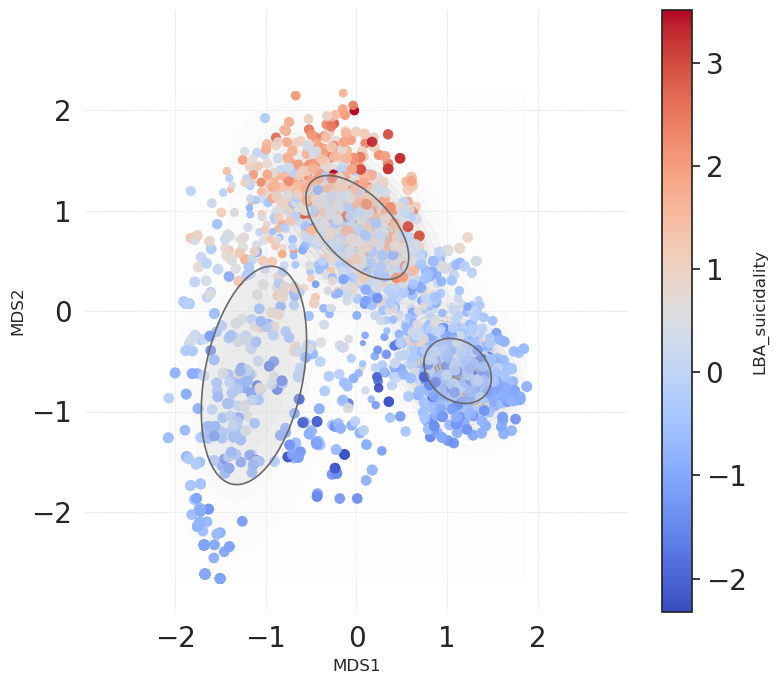

(<Figure size 800x700 with 2 Axes>, <Axes: xlabel='MDS1', ylabel='MDS2'>)

In [25]:
plot_bayesian_gaussian_mixture(dfs['d1'], 'MDS1', 'MDS2', "LBA_suicidality",3)

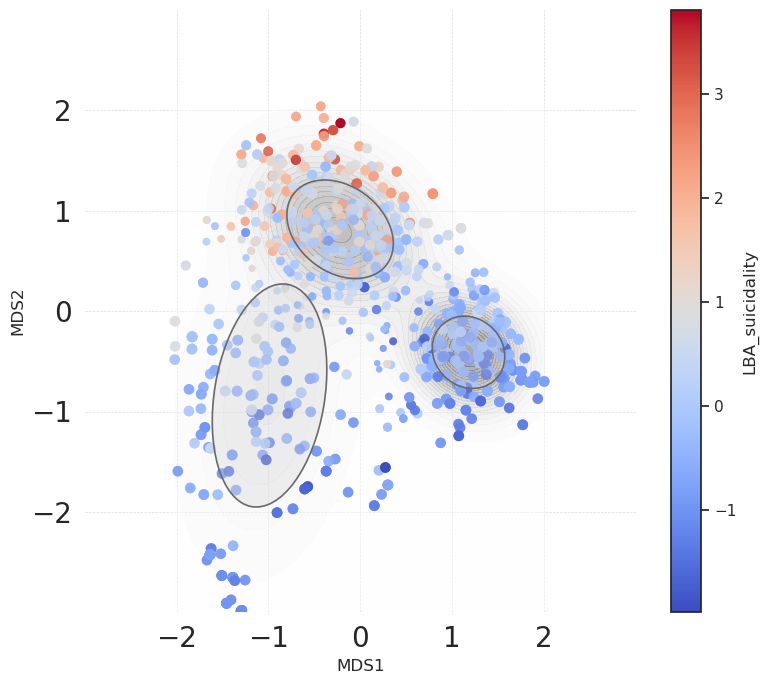

(<Figure size 800x700 with 2 Axes>, <Axes: xlabel='MDS1', ylabel='MDS2'>)

In [14]:
plot_bayesian_gaussian_mixture(dfs['d2'], 'MDS1', 'MDS2', "LBA_suicidality", 3)

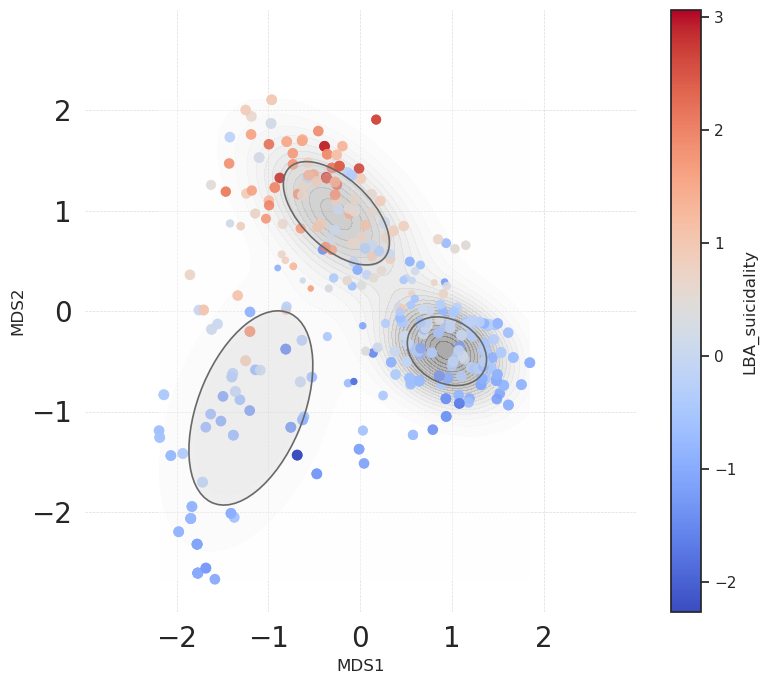

(<Figure size 800x700 with 2 Axes>, <Axes: xlabel='MDS1', ylabel='MDS2'>)

In [15]:
plot_bayesian_gaussian_mixture(dfs['d3'], 'MDS1', 'MDS2', "LBA_suicidality", 3)

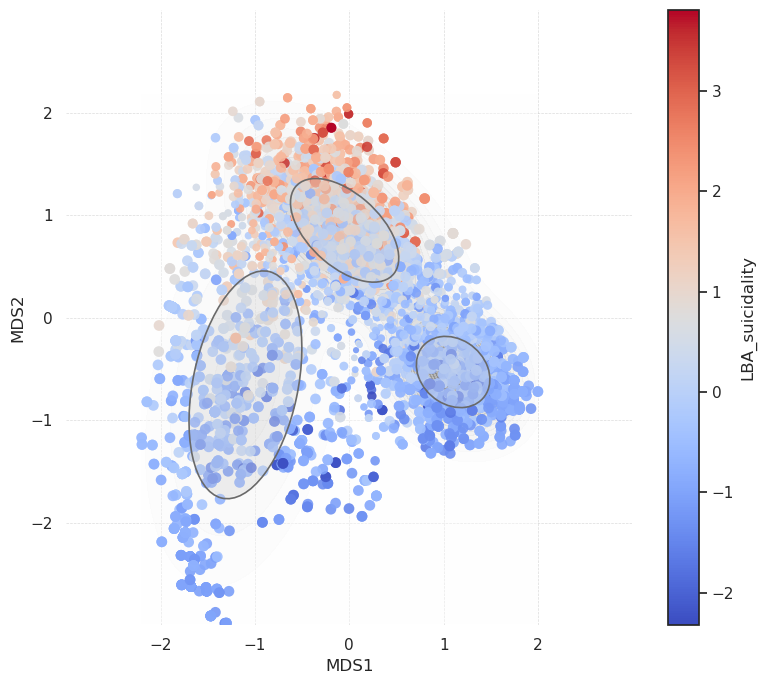

(<Figure size 800x700 with 2 Axes>, <Axes: xlabel='MDS1', ylabel='MDS2'>)

In [38]:
plot_bayesian_gaussian_mixture(dfs['tot'], 'MDS1', 'MDS2', "LBA_suicidality", 3)

# Test 1: scatter

<Axes: xlabel='MDS1', ylabel='MDS2'>

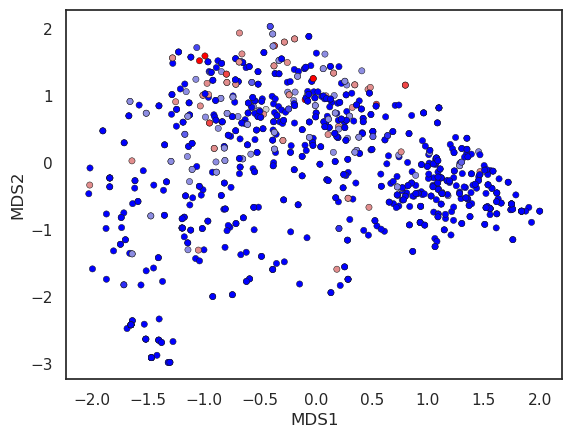

In [80]:
# Extract MDS coordinates and suicidality scores
x = df['MDS1']
y = df['MDS2']
c = df['expert_suicidality']

# Create grid
grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), 500),
    np.linspace(y.min(), y.max(), 500)
)

# Interpolate expert_suicidality values onto the grid
grid_c = griddata((x, y), c, (grid_x, grid_y), method='cubic')

# Define custom diverging colormap
colors = ['blue', 'lightgrey', 'red']
cmap = LinearSegmentedColormap.from_list("custom_diverging", colors)

# Normalize
vmin = np.nanmin(c)
vmax = np.nanmax(c)
mid_val = np.nanmedian(c)
if vmin < mid_val < vmax:
    norm = TwoSlopeNorm(vmin=vmin, vcenter=mid_val, vmax=vmax)
else:
    norm = Normalize(vmin=vmin, vmax=vmax)

# Plot with Seaborn style
sns.set_theme(style="white")

# fig, ax = plt.subplots(figsize=(10, 8))

# Use pcolormesh instead of imshow
# pc = ax.pcolormesh(grid_x, grid_y, grid_c, shading='auto', cmap=cmap, norm=norm)

# Overlay original points
sns.scatterplot(x=x, y=y, hue=c, palette=cmap, 
                # ax=ax, 
                edgecolor='k', s=20, legend=False)

# # Axis and title
# ax.set_xlabel('MDS1')
# ax.set_ylabel('MDS2')
# ax.set_title('Expert Suicidality Across MDS1 and MDS2')

# # Colorbar
# fig.colorbar(pc, ax=ax, label='Expert Suicidality')

# plt.tight_layout()
# plt.show()

# Test 2: contour line

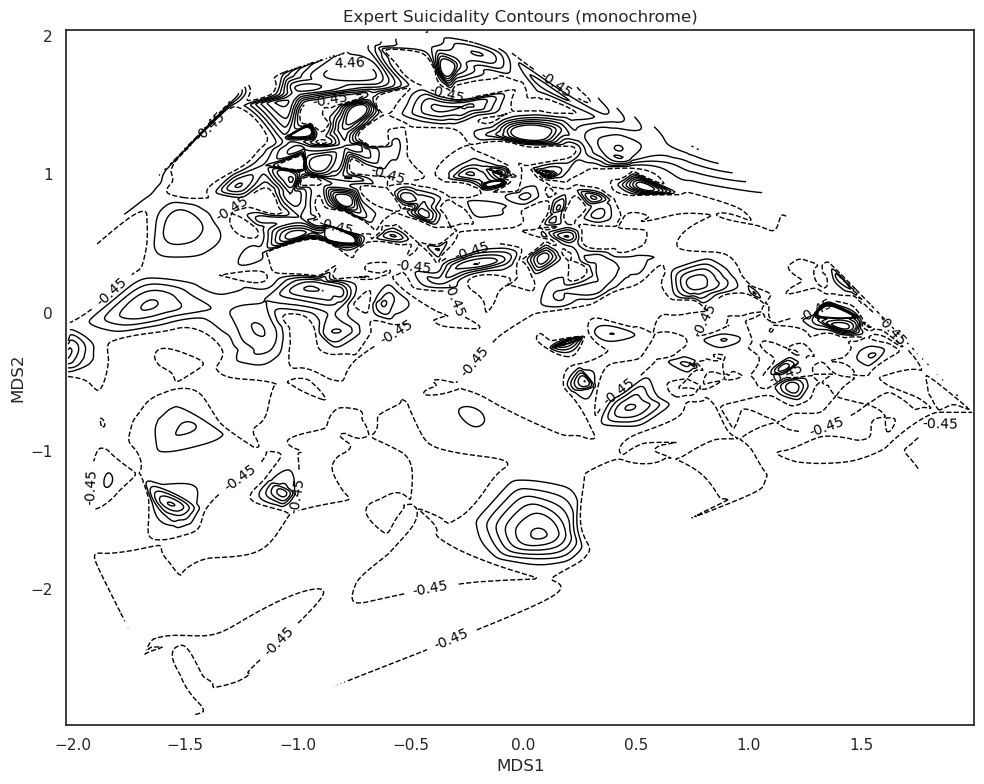

In [81]:
# ── 1.  Load or prepare your data ────────────────────────────────────────────
# df must contain columns: 'MDS1', 'MDS2', 'expert_suicidality'
# Example:
#   import pandas as pd
#   df = pd.read_csv("your_file.csv")

x = df['MDS1'].values
y = df['MDS2'].values
c = df['expert_suicidality'].values

# ── 2.  Create a dense grid covering the MDS space ───────────────────────────
grid_res = 500  # points along each axis
grid_x, grid_y = np.meshgrid(
    np.linspace(x.min(), x.max(), grid_res),
    np.linspace(y.min(), y.max(), grid_res)
)

# ── 3.  Interpolate suicidality scores onto the grid ─────────────────────────
grid_c = griddata((x, y), c, (grid_x, grid_y), method='cubic')

# ── 4.  Determine key contour levels ────────────────────────────────────────
v_min = np.nanmin(c)
v_med = np.nanmedian(c)
v_max = np.nanmax(c)

# Keep them unique and strictly increasing
key_levels = np.unique([v_min, v_med, v_max])
if key_levels.size < 2:          # all scores identical → add tiny offset
    eps = 1e-6
    key_levels = np.array([v_min - eps, v_min + eps])

# Add a few extra levels for visual context (optional)
context_levels = np.linspace(v_min, v_max, 7)
all_levels = np.unique(np.concatenate([key_levels, context_levels]))

# ── 5.  Plot ────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 8))

# Draw contour lines in black only
cs = ax.contour(
    grid_x, grid_y, grid_c,
    levels=all_levels,
    colors='black',
    linewidths=1
)

# Label just the min / median / max lines
ax.clabel(cs, levels=key_levels, inline=True, fontsize=10, fmt="%.2f")

# Axis labels and title
ax.set_xlabel('MDS1')
ax.set_ylabel('MDS2')
ax.set_title('Expert Suicidality Contours (monochrome)')

plt.tight_layout()
plt.show()